# Machine Vision 2022/23 - Assignment 5: Camera Calibration

In this assignment we will calibrate a camera using Tsai's camera calibration.

In [1]:
import copy
import math
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread

#### Tsai's Camera Calibration

The file `res/tsai/calibration.png` contains an image that shows a calibration scene with 16 calibration markers.
The position of the markers in world coordinates is stored in the array `var: (world_coordinates)`, while the positions of the image coordinates are stored in the array `var: (image_coordinates)`.

In [2]:
image = imread("res/tsai/calibration.png")

# Dimensions: [X, Y, Z] (xi, eta, zeta)
world_coordinates = np.array([
    [0.155, 0.301, 0],
    [0.720, 0.171, 0],
    [1.283, 0.171, 0],
    [1.934, 0.171, 0],
    [0.156, 1.194, 0],
    [0.156, 1.879, 0],
    [0.156, 2.552, 0],
    [1.110, 2.028, 0],
    [1.833, 1.258, 0],
    [0.192, 2.952, 0.602],
    [1.177, 2.952, 0.604],
    [1.979, 2.703, 0.615],
    [1.979, 1.817, 0.615],
    [1.979, 1.419, 0.615],
    [1.979, 0.433, 0.617],
    [0.899, 0.920, 0],
])

# Dimensions: [u, v]
image_coordinates = np.array([
    [135, 418],
    [307, 398],
    [436, 355],
    [552, 314],
    [81, 282],
    [56, 215],
    [39, 168],
    [216, 178],
    [393, 214],
    [29, 54],
    [178, 42],
    [300, 42],
    [370, 74],
    [411, 93],
    [530, 151],
    [262, 280],
])


##### Preparation

Visualize the image and the image coordinate of each marker.

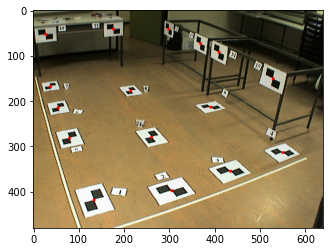

In [3]:
def plot_coordinates(*, image, image_coordinates, color):
    # @student: visualize the images and highlight the image coordinates in red
    #           the function should also return the marked image, as we will use it again later on
    image_marked = copy.deepcopy(image)
    for uv in image_coordinates:
        image_marked[uv[1]-3:uv[1]+3,uv[0]-3:uv[0]+3] = color
    plt.imshow(image_marked)
    plt.show()

    return image_marked

image_marked = plot_coordinates(image=image, image_coordinates=image_coordinates, color=[255,0,0])

##### Calculation

In [4]:
# This function calculates the eigenvector belonging to the smallest eigenvalue
def calculate_smallest_eigenvec(*, M):
    evals, evecs = np.linalg.eig(M)
    eigen_sorted = np.argsort(evals)
    eval = evals[eigen_sorted[0]]
    evec = evecs[:, eigen_sorted[0]]

    return evec, eval

In [5]:
def tsai(*, world_coordinates, image_coordinates):
    assert world_coordinates.shape[0] == image_coordinates.shape[0], "Each world coordinate must have a related image coordinate"
    num_matches = world_coordinates.shape[0]

    W = np.ones(shape=[num_matches, 4])
    W[:,:3] = world_coordinates

    # @student: build overdetermined coordinate system C based on (S, Su, Sv, Suv)
    S = np.zeros(shape=[4,4])
    Su = np.zeros(shape=[4,4])
    Sv = np.zeros(shape=[4,4])
    Suv = np.zeros(shape=[4,4])

    # For each match calculate S, Su, Sv and Suv
    for i in range(num_matches):
        s = np.outer(W[i], W[i])
        S += s
        Su += image_coordinates[i,1] * s
        Sv += image_coordinates[i,0] * s
        Suv += (np.square(image_coordinates[i, 0]) + np.square(image_coordinates[i, 1])) * s

    C = np.zeros(shape=[12,12])
    C[0:4, 0:4] = S
    C[4:8, 4:8] = S
    C[0:4, 8:12] = -Su
    C[8:12, 0:4] = -Su
    C[4:8, 8:12] = -Sv
    C[8:12, 4:8] = -Sv
    C[8:12, 8:12] = Suv

    # @student: find the eigenvector corresponding to the smallest eigenvalue
    evec, eval = calculate_smallest_eigenvec(M=C)


    # Scale the eigenvector based on the fact that M[3,0:3] is equal to one row of the rotation matrix
    # Therefore, its euclidean length must be 1
    # However, there are still two possibilities either -evec / ... or + evec/...
    # We can choose the correct one by checking the determinant of the rotation matrix
    # @student: Scale +/-eigenvector
    evec_pos = evec / np.sqrt(np.square(evec[8]) + np.square(evec[9]) + np.square(evec[10]))
    evec_neg = -evec / np.sqrt(np.square(evec[8]) + np.square(evec[9]) + np.square(evec[10]))

    found = False
    # evaluate +/- eigenvector
    for evec in [evec_pos, evec_neg]:
        # @student: reshape eigenvector to M[3, 4]
        M = np.reshape(evec, [3, 4])

        # @student: define output matrices, A, R, t
        A = np.zeros(shape=[3,3])
        R = np.zeros(shape=[3,3])
        t = np.zeros(shape=[1,3]) #fix

        # @student: determine A,R,t parameter from M
        R[2,:] = M[2,0:3]
        t[0, 2] = M[2,3]
        v0 = np.dot(M[2, 0:3], M[1, 0:3])
        u0 = np.dot(M[2, 0:3], M[0, 0:3])

        beta_pp = np.sqrt(np.dot(M[1,0:3], M[1,0:3]) - np.square(v0))
        t[0,1] = (M[1,3] - v0 * t[0, 2]) / beta_pp
        R[1,:] = (M[1, 0:3] - v0 * R[2,:]) / beta_pp
        gamma_pp = (u0*v0 - np.dot(M[0,0:3], M[1,0:3])) / beta_pp

        alpha_pp = np.sqrt(np.dot(M[0,0:3], M[0,0:3]) + np.square(gamma_pp) - np.square(u0))
        R[0, :] = (M[0,0:3] + (gamma_pp*R[1,:]) - (u0 * R[2,:])) / alpha_pp
        t[0,0] = (M[0,3] + (gamma_pp * t[0,1]) - (u0 * t[0,2])) / alpha_pp

        A[0,0] = alpha_pp
        A[0,1] = gamma_pp
        A[1,1] = beta_pp
        A[0,2] = u0
        A[1,2] = v0
        A[2,2] = 1

        if math.isclose(1, np.linalg.det(R), abs_tol=0.001):
            found = True
            break

    assert found == True, "Either the positive nor negative rotation matrix must have a determinant of 1"
    return A, R, t

A, R, t = tsai(world_coordinates=world_coordinates, image_coordinates=image_coordinates)

##### Evaluation

In order to evaluate the calibration, we can project our known world points into the image and calculate the reprojection error.

First we need to transform our coordinated and parameters to homogeneous form.

In [6]:
# @student: transform A, R, t into homogeneous form (var: A_h, Rt_h)
#           transform world coordinates into homogeneous form (var: WC_h)

# Rt_h
Rt_h = np.zeros(shape=[4,4])
Rt_h[0:3,0:3] = R
Rt_h[0:3, 3] = t
Rt_h[3,3] = 1

# A_h
A_h = np.zeros(shape=[4,4])
A_h[0:3, 0:3] = A
A_h[3, 3] = 1

# WC_h
WC_h = np.zeros(shape=[16, 4])
WC_h[:, :3] = world_coordinates
WC_h[:, 3] = 1
WC_h = WC_h.transpose()

then we can project the world coordinated to image space.


$
z * \begin{bmatrix}u' \\ v' \\ 1\end{bmatrix} = A_h * Rt_h * \begin{bmatrix} \xi \\ \eta \\ \zeta \\ 1\end{bmatrix},
$
where $A_h$ and $Rt_h$ are $A$ and $Rt$ in homogeneous form.

In [7]:
# @student: Calculate 2D projection using A_h, Rt_h and WC_h
projection = np.matmul(Rt_h, WC_h)
projection = np.matmul(A_h, projection) / projection[2, :]
projection = projection[0:2, :]

# this flip is important as 0 = v and 1 = u
# in the result
pt = copy.deepcopy(projection[0,:])
projection[0,:] = projection[1,:]
projection[1,:] = pt

projection = projection.transpose()

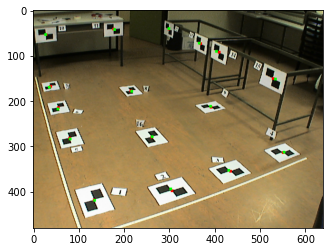

In [8]:
image_marked = plot_coordinates(image=image_marked, image_coordinates=projection.astype(np.int32), color=[0,255,0])

Once the projected pixel $p'$ ($u'$, $v'$) is calculated based on the calibration parameters it can be compared with the known pixel $p$ ($u$, $v$).

The resulting error is called reprojection error $e_r$, which can be calculated using the equation:

$e_r = 1/N * \sum{|p - p'|_2}$, where N is the number of pixels and ||_2 is the L2-Norm.

In [9]:
def calculate_reprojection_error(*, p, p_pred) -> float:
    # @student: calculate the reprojection error
    return np.sqrt(np.square(p - p_pred)).mean()

calculate_reprojection_error(p=image_coordinates, p_pred=projection)

1.8749156726317615